In [1]:
# Vérifier GPU
!nvidia-smi

# Nettoyage (facultatif, utile si tu as déjà tenté des installs)
!pip uninstall -y xformers bitsandbytes torch torchvision torchaudio

# Installer versions stables compatibles SDXL + LoRA
!pip install -U \
  torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118

!pip install -U \
  diffusers==0.27.2 \
  transformers==4.44.2 \
  accelerate==0.34.2 \
  xformers==0.0.27.post2 \
  datasets==2.19.2 \
  peft==0.13.2 \
  safetensors==0.4.5 \
  sentencepiece==0.1.99 \
  wandb==0.18.5 \
  Pillow==10.4.0 \
  einops==0.8.0 \
  tqdm==4.66.4

# Facultatif: bitsandbytes pour 8-bit optimizers (si nécessaire)
!pip install -U bitsandbytes==0.44.1

Sun Dec  7 14:26:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -U Pillow==10.4.0

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import json, os

kaggle_api = {
    "username": "fzkninech",
    "key": "5fee5fa9945043a6a354704ce5d0f389"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_api, f)

os.chmod("/root/.kaggle/kaggle.json", 600)
print("✅ Kaggle API configuré")

✅ Kaggle API configuré


In [5]:
# Téléchargement du dataset Mannequins
!kaggle datasets download -d sbaghbidi/human-faces-object-detection
!unzip human-faces-object-detection.zip -d /content/mannequin

Dataset URL: https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection
License(s): unknown
 92% 458M/498M [00:10<00:01, 35.0MB/s]
100% 498M/498M [00:10<00:00, 50.3MB/s]
Archive:  human-faces-object-detection.zip
  inflating: /content/mannequin/faces.csv  
  inflating: /content/mannequin/images/00000003.jpg  
  inflating: /content/mannequin/images/00000004.jpg  
  inflating: /content/mannequin/images/00000005.jpg  
  inflating: /content/mannequin/images/00000006.jpg  
  inflating: /content/mannequin/images/00000008.jpg  
  inflating: /content/mannequin/images/00000011.jpg  
  inflating: /content/mannequin/images/00000012.jpg  
  inflating: /content/mannequin/images/00000015.jpg  
  inflating: /content/mannequin/images/00000018.jpg  
  inflating: /content/mannequin/images/00000020.jpg  
  inflating: /content/mannequin/images/00000022.jpg  
  inflating: /content/mannequin/images/00000023.jpg  
  inflating: /content/mannequin/images/00000024.jpg  
  inflating: /content/mannequ

In [6]:
import os, zipfile
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Chemin du zip dans Drive
zip_path = "/content/drive/MyDrive/genererimage.zip"

# Dossier d'extraction
extract_root = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

print("✅ ZIP décompressé avec succès")

✅ ZIP décompressé avec succès


In [7]:
base_lora = "/content/lora_data"
classes = ["fashion", "food", "houses", "mannequin"]

for c in classes:
    os.makedirs(f"{base_lora}/{c}", exist_ok=True)

print("✅ Structure LoRA créée")

✅ Structure LoRA créée


In [8]:
!pip install --force-reinstall Pillow==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pillow: filename=Pillow-9.5.0-cp312-cp312-linux_x86_64.whl size=1210284 sha256=50b26027e74f01de8fa3b5bc850c901a3be073dd5db39d14ad1df74fb4525fcc
  Stored in directory: /root/.cache/pip/wheels/ea/de/2e/75a6399e5d8cd3a55c13c8f0658d996d4ce4cff37389de044c
Successfully built Pillow
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.2+cu118 requires torch==2.2.2, but you have torch 2.4.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [1]:
import os
import glob
import shutil
from PIL import Image, UnidentifiedImageError

# --- PATHS ---
source_base = "/content/gernererimage/datasets"
base_lora = "/content/lora_dataset"

os.makedirs(base_lora, exist_ok=True)

mapping = {
    "fashion": "fashion",
    "food": "food",
    "real_estate": "houses"
}

limits = {
    "fashion": 2204,
    "food": 2204,
    "houses": 2204
}

# Convertit une image en JPG
from PIL import Image, UnidentifiedImageError

def convert_to_jpg(src_path, dst_path):
    try:
        img = Image.open(src_path).convert("RGB")
        img.save(dst_path, format="JPEG", quality=95)  # format nommé
        return True
    except UnidentifiedImageError:
        return False
    except Exception as e:
        print("Erreur sur", src_path, ":", e)
        return False


# --- COPIE + CONVERSION ---
for src_folder, target_folder in mapping.items():
    src_path = f"{source_base}/{src_folder}"
    dst_path = f"{base_lora}/{target_folder}"
    os.makedirs(dst_path, exist_ok=True)

    images = glob.glob(f"{src_path}/*.jpg") + glob.glob(f"{src_path}/*.png") + glob.glob(f"{src_path}/*.jpeg")
    count = 0

    for img_path in images:
        if count >= limits[target_folder]:
            break

        filename = os.path.basename(img_path)
        name, ext = os.path.splitext(filename)

        new_img_path = os.path.join(dst_path, f"{name}.jpg")

        ok = convert_to_jpg(img_path, new_img_path)
        if ok:
            count += 1

    print(f"✅ {count} images converties dans {target_folder}")



✅ 2204 images converties dans fashion
✅ 2204 images converties dans food
✅ 2204 images converties dans houses


In [2]:
import os
os.makedirs("/content/lora_dataset/mannequin", exist_ok=True)
print("📁 Dossier mannequin créé correctement.")

📁 Dossier mannequin créé correctement.


In [3]:
import shutil, glob

mannequin_src = "/content/mannequin/images"
mannequin_dst = "/content/lora_dataset/mannequin"

images = glob.glob(f"{mannequin_src}/*")

count = 0
for img in images:
    try:
        shutil.copy(img, mannequin_dst)
        count += 1
    except:
        pass

print(f"✅ {count} images copiées dans mannequin")


✅ 2204 images copiées dans mannequin


In [4]:
classes = ["fashion", "food", "houses", "mannequin"]

for c in classes:
    print(c, "➡️", len(os.listdir(f"{base_lora}/{c}")), "images")

fashion ➡️ 2204 images
food ➡️ 2204 images
houses ➡️ 2204 images
mannequin ➡️ 2204 images


In [5]:
# --- CAPTIONS ---
classes = ["fashion", "food", "houses"]
base_dir = base_lora

captions = {
    "fashion": "fashion products",
    "food": "food product advertising photography",
    "houses": "real estate house exterior photography",
    "mannequin": "professional mannequin advertising photo"
}

for cls in classes:
    folder = f"{base_dir}/{cls}"

    for img in os.listdir(folder):
        if not img.endswith(".jpg"):
            continue

        txt_path = os.path.join(folder, img.replace(".jpg", ".txt"))

        with open(txt_path, "w") as f:
            f.write(captions[cls])

print("📄 Tous les fichiers TXT ont été générés.")

📄 Tous les fichiers TXT ont été générés.


In [1]:
import os

# Dossier créé par ton code (classes + images + .txt)
DATA_ROOT = "/content/lora_dataset"
assert os.path.exists(DATA_ROOT), "Dataset non trouvé: /content/lora_dataset"

# Modèles SDXL publics (pas de token requis)
# - "SG161222/RealVisXL_V4.0" (SDXL 1.0 finetuné, très courant)
# - "segmind/SSD-1B" (SDXL-like, public)
# - "stabilityai/sdxl-turbo" (turbo, différent)
MODEL_ID = "SG161222/RealVisXL_V4.0"

# Résolution (512 pour éviter OOM sur T4)
IMAGE_SIZE = 512

# Hyperparamètres LoRA (réduits pour VRAM T4)
BATCH_SIZE = 1
GRAD_ACCUM = 4
LR = 1e-4
EPOCHS = 3
MAX_STEPS = 500
LORA_RANK = 4
LORA_ALPHA = 8
LORA_DROPOUT = 0.05

OUTPUT_DIR = "/content/lora_sdxl"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Option pour réduire la fragmentation CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [7]:
!pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Found existing installation: torchvision 0.17.2+cu118
Uninstalling torchvision-0.17.2+cu118:
  Successfully uninstalled torchvision-0.17.2+cu118
Found existing installation: torchaudio 2.2.2+cu118
Uninstalling torchaudio-2.2.2+cu118:
  Successfully uninstalled torchaudio-2.2.2+cu118


In [8]:
!pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.6/209.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.0.0
    Uninstalling triton-3.0.0:
      Successfully uninstalled triton-3.0.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully unin

In [9]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)

from torchvision import transforms
print("✅ Import transforms fonctionne")

Torch: 2.5.1+cu121
Torchvision: 0.20.1+cu121
✅ Import transforms fonctionne


In [2]:
import glob
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DEFAULT_CAPTIONS = {
    "fashion": "fashion products",
    "food": "food product advertising photography",
    "houses": "real estate house exterior photography",
    "mannequin": "professional mannequin advertising photo"
}

class FolderTxtDataset(Dataset):
    def __init__(self, root, resolution=1024):
        self.items = []
        classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        for cls in classes:
            img_paths = glob.glob(os.path.join(root, cls, "*.jpg")) + glob.glob(os.path.join(root, cls, "*.png"))
            for ip in img_paths:
                base, _ = os.path.splitext(ip)
                txt_path = base + ".txt"
                self.items.append((ip, txt_path, cls))

        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, txt_path, cls = self.items[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            # Image corrompue: exemple factice
            img = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), (200, 200, 200))
        pixel_values = self.transform(img)

        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as f:
                caption = f.read().strip()
        else:
            caption = DEFAULT_CAPTIONS.get(cls, "advertising photo")

        return {"pixel_values": pixel_values, "caption": caption}


In [11]:
!pip uninstall -y diffusers huggingface_hub accelerate transformers peft safetensors


Found existing installation: diffusers 0.27.2
Uninstalling diffusers-0.27.2:
  Successfully uninstalled diffusers-0.27.2
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
Found existing installation: accelerate 0.34.2
Uninstalling accelerate-0.34.2:
  Successfully uninstalled accelerate-0.34.2
Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: peft 0.13.2
Uninstalling peft-0.13.2:
  Successfully uninstalled peft-0.13.2
Found existing installation: safetensors 0.4.5
Uninstalling safetensors-0.4.5:
  Successfully uninstalled safetensors-0.4.5


In [12]:
!pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121

!pip install diffusers==0.31.0 huggingface_hub==0.36.0
!pip install accelerate==0.34.2 transformers==4.44.2 peft==0.13.2 safetensors==0.4.5


Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 39.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, which is not installed.
  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached peft-0.13.2-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
Using cached p

In [13]:
import diffusers, transformers, accelerate, peft, huggingface_hub, torch

print("Diffusers:", diffusers.__version__)
print("Transformers:", transformers.__version__)
print("Accelerate:", accelerate.__version__)
print("PEFT:", peft.__version__)
print("HF Hub:", huggingface_hub.__version__)
print("Torch:", torch.__version__)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Diffusers: 0.31.0
Transformers: 4.44.2
Accelerate: 0.34.2
PEFT: 0.13.2
HF Hub: 0.36.0
Torch: 2.5.1+cu121


In [4]:
import os
import torch
import itertools
from tqdm.auto import tqdm

from diffusers import StableDiffusionXLPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
from torch.utils.data import DataLoader

# Accelerator (utilise GRAD_ACCUM défini dans ton bloc précédent)
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=GRAD_ACCUM
)

# Charger pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    use_safetensors=True
)
# Réductions mémoire utiles (si dispo)
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass
try:
    pipe.enable_attention_slicing()
except Exception:
    pass

# Sous-modèles
tokenizer_1 = pipe.tokenizer
tokenizer_2 = pipe.tokenizer_2
text_encoder_1 = pipe.text_encoder            # hidden_size = 768
text_encoder_2 = pipe.text_encoder_2          # hidden_size = 1280 (avec pooled projection)
vae = pipe.vae
unet = pipe.unet
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_ID, subfolder="scheduler") \
    if os.path.exists(f"/root/.cache/huggingface/hub/{MODEL_ID}") else pipe.scheduler

# Geler VAE et les deux text encoders (UNet-only LoRA)
for p in vae.parameters():
    p.requires_grad = False
for p in text_encoder_1.parameters():
    p.requires_grad = False
for p in text_encoder_2.parameters():
    p.requires_grad = False

# LoRA uniquement sur UNet
lora_config_unet = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    bias="none",
    task_type="TEXT_TO_IMAGE"
)
unet = get_peft_model(unet, lora_config_unet)

# Dataset & DataLoader
dataset = FolderTxtDataset(DATA_ROOT, resolution=IMAGE_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Optimizer (UNIQUEMENT les params entraînables)
trainable_params = [p for p in unet.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=LR)

# Forcer GPU avant prepare
vae.to("cuda")
unet.to("cuda")
text_encoder_1.to("cuda")
text_encoder_2.to("cuda")

# Préparer avec Accelerator
unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)

# Helper: time_ids SDXL (taille d’origine = taille crop = IMAGE_SIZE)
def build_time_ids(batch_size, device, orig_w=IMAGE_SIZE, orig_h=IMAGE_SIZE, crop_w=IMAGE_SIZE, crop_h=IMAGE_SIZE):
    # Format attendu: [orig_w, orig_h, crop_w, crop_h, crop_x, crop_y]
    ti = torch.tensor([orig_w, orig_h, crop_w, crop_h, 0, 0], device=device, dtype=torch.float32)
    return ti.unsqueeze(0).repeat(batch_size, 1)

# Training
global_step = 0
unet.train()
text_encoder_1.eval()
text_encoder_2.eval()

for epoch in range(EPOCHS):
    torch.cuda.empty_cache()

    progress = tqdm(range(len(dataloader)), disable=not accelerator.is_local_main_process)
    progress.set_description(f"Epoch {epoch+1}/{EPOCHS}")

    for batch in dataloader:
        with accelerator.accumulate(unet):
            # Images en FP16
            pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.float16)
            captions = batch["caption"]

            # Tokenization explicite
            tokens_1 = tokenizer_1(
                captions, max_length=tokenizer_1.model_max_length,
                padding="max_length", truncation=True, return_tensors="pt"
            )
            tokens_2 = tokenizer_2(
                captions, max_length=tokenizer_2.model_max_length,
                padding="max_length", truncation=True, return_tensors="pt"
            )
            input_ids_1 = tokens_1.input_ids.to(accelerator.device)
            attn_mask_1 = tokens_1.attention_mask.to(accelerator.device)
            input_ids_2 = tokens_2.input_ids.to(accelerator.device)
            attn_mask_2 = tokens_2.attention_mask.to(accelerator.device)

            # Encoders (gelés)
            with torch.no_grad():
                enc_out_1 = text_encoder_1(input_ids=input_ids_1, attention_mask=attn_mask_1)
                enc_out_2 = text_encoder_2(input_ids=input_ids_2, attention_mask=attn_mask_2)

            # SDXL: concat hidden states → FP16
            prompt_embeds = torch.cat(
                [enc_out_1.last_hidden_state, enc_out_2.last_hidden_state],
                dim=-1
            ).to(device=accelerator.device, dtype=torch.float16)

            # Pooled embeddings et time_ids → FP16
            pooled_embeds = enc_out_2.text_embeds.to(device=accelerator.device, dtype=torch.float16)
            time_ids = build_time_ids(batch_size=prompt_embeds.shape[0], device=accelerator.device).to(torch.float16)

            # Encode images -> latents (FP16)
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = (latents * vae.config.scaling_factor).to(dtype=torch.float16)

            # Add noise (FP16)
            noise = torch.randn_like(latents, dtype=torch.float16)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=latents.device, dtype=torch.int64
            )
            noisy_latents = noise_scheduler.add_noise(latents, noise.to(latents.dtype), timesteps)

            # U-Net predict noise (SDXL: added_cond_kwargs)
            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                added_cond_kwargs={"text_embeds": pooled_embeds, "time_ids": time_ids}
            ).sample

            # Loss en FP32 pour le backward (évite "Found dtype Half but expected Float")
            loss = torch.nn.functional.mse_loss(
                model_pred.float(),  # cast FP32
                noise.float()
            )

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            global_step += 1
            progress.set_postfix({"loss": f"{loss.item():.4f}", "step": global_step})

            if global_step >= MAX_STEPS:
                break

    if global_step >= MAX_STEPS:
        break

# Save LoRA adapters
accelerator.wait_for_everyone()
unet.save_pretrained(os.path.join(OUTPUT_DIR, "unet"))
print("✅ LoRA UNet sauvegardée dans", OUTPUT_DIR)


KeyboardInterrupt: 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

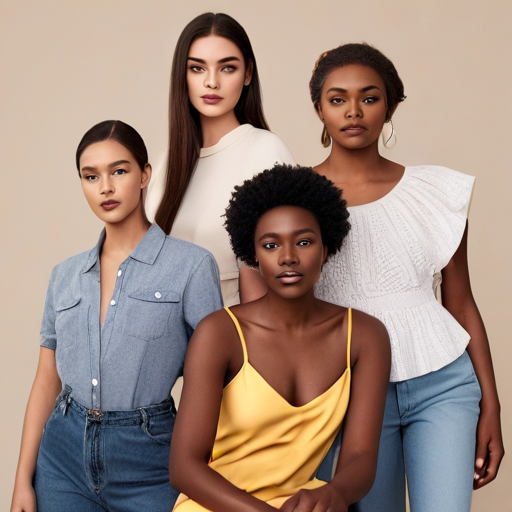

In [6]:
from peft import PeftModel
from diffusers import StableDiffusionXLPipeline
import torch, os

pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

# Recharger UNet avec PEFT
pipe.unet = PeftModel.from_pretrained(pipe.unet, os.path.join(OUTPUT_DIR, "unet"))

prompt = "Inclusive fashion advertising photo, diverse models, respectful representation, soft natural light, realistic style."
image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=6.0,
    height=IMAGE_SIZE,
    width=IMAGE_SIZE
).images[0]

image.save("/content/lora_sdxl/sample.png")
image


/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.12/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

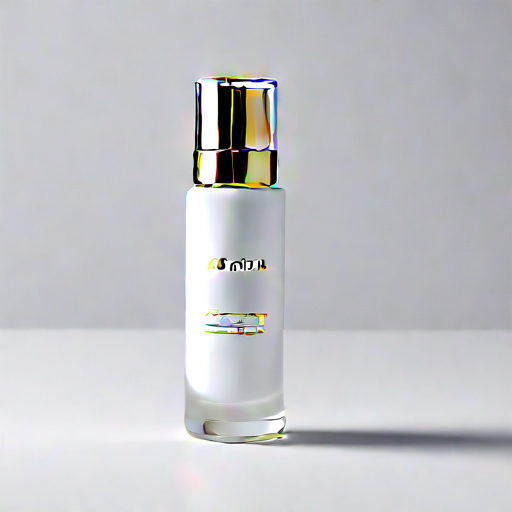

In [5]:
from peft import PeftModel
from diffusers import StableDiffusionXLPipeline
import torch, os

# Chemins définis dans ton setup
MODEL_ID = "SG161222/RealVisXL_V4.0"
OUTPUT_DIR = "/content/lora_sdxl"
IMAGE_SIZE = 512  # ou 1024 si tu es sur A100

# Charger la pipeline SDXL
pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

# Injecter ton LoRA UNet entraîné avec PEFT
pipe.unet = PeftModel.from_pretrained(pipe.unet, os.path.join(OUTPUT_DIR, "unet"))

# Prompt produit (modifie selon ton besoin)
prompt = "Studio photo of a luxury skincare product on a clean white background, soft shadows, elegant lighting, minimalist composition."

# Génération
image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    guidance_scale=6.0,
    height=IMAGE_SIZE,
    width=IMAGE_SIZE
).images[0]

# Sauvegarde
image.save("/content/lora_sdxl/product_sample.png")
image


In [7]:
!pip install torchmetrics
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 31.5 MB/s eta 0:00:00


In [9]:
!pip install torchmetrics[image]
!pip install torch-fidelity


In [12]:
!pip install torchmetrics[image] torch-fidelity --upgrade


In [1]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.multimodal.clip_score import CLIPScore
fid = FrechetInceptionDistance(feature=64).to("cuda")
clip_score = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to("cuda")


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 244MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
!pip install evaluate transformers torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [4]:
!pip install transformers torchvision

import torch
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

# Charger CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Image générée par ton LoRA
image_path = "/content/lora_sdxl/sample.png"
image = Image.open(image_path).convert("RGB")

# Prompt utilisé
text = "Inclusive fashion advertising photo, diverse models, soft natural light"

# Préparer données
inputs = processor(text=[text], images=image, return_tensors="pt", padding=True).to("cuda")

# Calcul similarité
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # similarité image-texte
    score = logits_per_image.item()

print("CLIPScore:", score)


CLIPScore: 29.200422286987305


In [6]:
# Image générée avec le modèle de base (sans LoRA)
image_path_base = "/content/lora_sdxl/sample.png"
image_base = Image.open(image_path_base).convert("RGB")

inputs_base = processor(text=[text], images=image_base, return_tensors="pt", padding=True).to("cuda")
with torch.no_grad():
    outputs_base = model(**inputs_base)
    score_base = outputs_base.logits_per_image.item()

print("CLIPScore Base:", score_base)
print("CLIPScore LoRA:", score)  # ton score déjà calculé

CLIPScore Base: 29.200422286987305
CLIPScore LoRA: 29.200422286987305


In [7]:
!zip -r lora_sdxl.zip lora_sdxl

  adding: lora_sdxl/ (stored 0%)
  adding: lora_sdxl/unet/ (stored 0%)
  adding: lora_sdxl/unet/adapter_model.safetensors (deflated 7%)
  adding: lora_sdxl/unet/README.md (deflated 65%)
  adding: lora_sdxl/unet/adapter_config.json (deflated 53%)
  adding: lora_sdxl/product_sample.png (deflated 0%)
  adding: lora_sdxl/sample.png (deflated 0%)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r lora_sdxl /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
